# PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp


Recall that we introduced the basic theories about hierachical modelling of sea-level in last tutorial, in summary it can be represented as:

<img width=700px src="Hierachical_framework.png"/>

We've covered data level modelling in the last notebook, so in this tutorial, we will go through the `process level modelling' which is often the most important section for sea-level modelling research.

### Process level

The process level is hierarchical level at which the variability of sea-levle change is modeled and in some cases, decomposed based on data model. The process level reflects our understandings of sea-level change processes. For simplicity, we introduce process level for modelling temporal sea-level processes here, but it can be easily extended to a higher dimension (e.g., spatio-temporal). Some typical methods used for represent process level of sea-level change are (we will go through each of them in this tutorial):

&#10148; **1. Any kind of hand-drawn curve:** Intuitively draw a curve to fit the observational data by hand. An example below from [Zong 2004](https://www.sciencedirect.com/science/article/pii/S1040618203001162?casa_token=hduIZdtNm-QAAAAA:hlPhRyw9NWqKl7pz3oakuR6K1JiVyAbhukAZshFbOMLGGg0jhAVuomutQdkDUOgolnSgfixwSQ) shows hand-drawn RSL curves for Southeast China during Holocene

<img width=800px src="Drawn_RSL.png"/>


&#10148; **2. Linear/polynomial model:** Assuming sea-level changes based on a certain kind of polynomial function (i.e., first-order polynomial equals temporally linear model, second-order polynomial can introduce a further parameter to control the rate of RSL change; acceleration/deceleration, etc...). An example below from [Lin et al., 2021](https://www.nature.com/articles/s41467-021-21990-y) assumes RSL change linearly during [Meltwater Pulse 1A](https://en.wikipedia.org/wiki/Meltwater_pulse_1A).

<img width=800px src="MWP_RSL.png"/>

&#10148; **3. Change-point model**: An extention of linear/polynomial model where a change-point model identifies points in the data where the rate of sea-level change can be significantly differnet before and after these points. An exmaple below from [Lambeck et al., 2014](https://www.pnas.org/doi/abs/10.1073/pnas.1411762111) uses a change point model approach to reconstruct global ice-equivalent sea-level from the 35 ka BP to present. 

<img width=800px src="ESL.png"/>

&#10148; **4. Gaussian Process model**: An nonparametric and Bayesian approach, to infer temporal variation of sea-level change based on covariance matrix estimated conditional upon the data. Compared to using other parametric models (e.g., polynomial, change-point model) to infer time series, GP time-series models have much more flexibility. An example below from [Tan et al., (2022)](https://www.sciencedirect.com/science/article/pii/S0277379123000434#fig3) shows relative sea-level change estimated based on a Gaussian Process modern conditioned on RSL data. 

<img width=400px src="GP_RSL.png"/>


&#10148; **5. Physical model**: RSL is predicted by the physical governing equations and specific physical parameters, such as ice history and Earth rheology for a glacial isostatic adjustment (GIA) model. An example below from [Simon et al., 2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB023693) shows different GIA model predictions in comparison to RSL data. 

<img width=800px src="Physical_RSL.png"/>

&#10148; **6. Mixed physical and statistical model or data assimilation**: This approach combined physical model with observational data (which can be represented by statistical models) to improve the accuracy and  reliability of predictions. An exmaple below from [Creel et al., 2022](https://www.sciencedirect.com/science/article/pii/S0277379122000531?casa_token=pY88KBJVoMgAAAAA:tlgDNf7iZ5hOKiPY9L5b5eA-Q_XMhlYtDSaBDjPZMdNjDPb1Kw3uaeRPp6ayyaijXn4EytwzOw#fig3) used an ensemble of GIA model to predict RSL at time and location where RSL data located at with different physical parameter combinations, they then update those physical model preidctions using a Guassian Process appraoch.

<img width=800px src="Norwary_RSL.png"/>

### Parameter Level

The parameter level captures key attributes of the data and process levels through unobserved parameters, which can be physical or statistical parameters. With parameter level model, we can reflect our prior knowledge on the final prediction. For example, if we are using a Gaussian Process model to infer sea-level change rate, an important hyperparameter we need to define is length scale. If we have no idea whether sea-level change in your sites will be short-wavelength or long-wavelenth, we can set a non-informative prior to this hyperparameter. However, if we have some ideas about how sea-level may change here, commonly from physical insights, we can set the lengthscale to a certain plausible range. 


### Illustrative example: New Jersey sea-level trend and rate modelling

To illustrate different process level models and see their difference in prediction performances, we will use real sea-level data from New Jersey ([Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740)), which contains 135 sea-level data points each with: reconstructed RSL, age, RSL reconstructeion uncertainty and age uncertainty. The data model used here assumes age and RSL are both distributed normally. Let's check the data first. Note, we will now start to use PaleoSTeHM module (PSTHM), which contains python functions to load/plot data, create/optimize statistical model.  

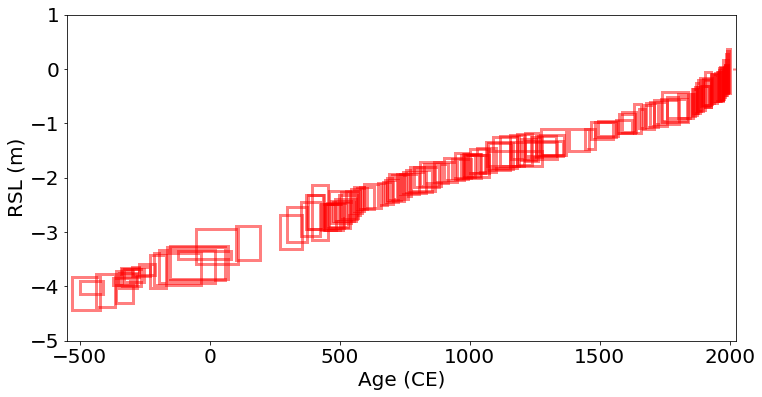

In [4]:
import sys
sys.path.append('../../Code')
import PSTHM 
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)

#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load_local_rsl_data('../../Data/NJ_CC.csv')
X,X_index = torch.sort(X)
y = y[X_index]
y_sigma = y_sigma[X_index]
x_sigma = x_sigma[X_index]
lon = torch.tensor(lon)[X_index]
lat = torch.tensor(lat)[X_index]
#visualize data
ax = PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

Remember that we assume both the RSL and age model to be normally distributed, as plotting their 2D distribution will be pretty noisy and hard to see, we plot 2-sigma uncertainty box instead. And we can start to test different process level models on it. And we will define model performances by weighted mean squared error (wMSE), the weighting factor for each data point is its vertical 1-sigma uncertainty. 

#### 1. Hand-drawn curve

It seems to me that sea-level rose constantly from -500 to 1200 CE. After that sea-level rise rate slightly dropped until 1800 when sea-level started to rise much more rapidly. I can generate my intuitive curve by setting several points and link them. 

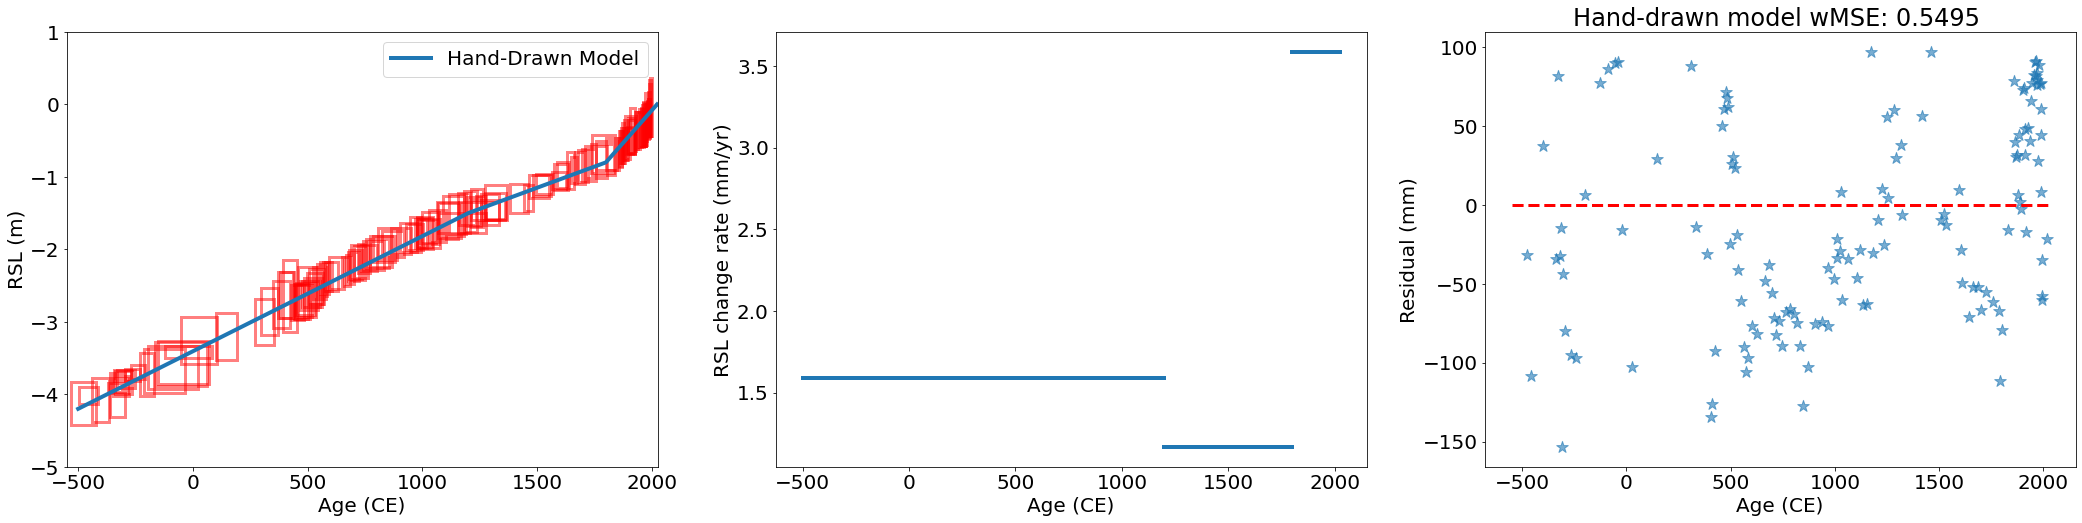

In [11]:
from scipy import interpolate
hand_model_x = [-500,1200,1800,2023]
hand_model_y = [-4.2,-1.5,-0.8,0]

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(hand_model_x,hand_model_y,color='C0',linewidth=4,label='Hand-Drawn Model')
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
hand_model_rate = np.diff(hand_model_y)/np.diff(hand_model_x)*1000
for i in range(len(hand_model_rate)):
    plt.plot([hand_model_x[i],hand_model_x[i+1]],[hand_model_rate[i],hand_model_rate[i]],color='C0',linewidth=4)
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')

ax3 = plt.subplot(133)
f_hand = interpolate.interp1d(hand_model_x,hand_model_y)
hand_prediction = f_hand(X)
plt.scatter(X,(hand_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.title('Hand-drawn model wMSE: {:4.4f} '.format(PSTHM.cal_wMSE(y.detach().numpy(),hand_prediction,y_sigma.detach().numpy())))
plt.show()



We can see that the hand-drawn model is actually doing a great job, so for this problem, human intuition do provides some insights. And let's try other process models.

#### 2. Linear/polynomial model

For a linear model, the process level of temporal sea-level change can be written as:
$$
f_{linear}(\overline{t}_{i}) = \overline{t}_{i} \times a + b\\
$$
where $a$ is a sea-level rise rate coefficient, $b$ is a intercept coefficient, indicating sea-level when time is 0. Intergrate this parameter level model with data level model we get:

$$
y = f_{linear}(\overline{t}_{i}) + \epsilon_{i}\\
  =  \overline{t}_{i} \times a + b + \epsilon_{i}\\
$$
where:
$$
t_{i}  = \overline{t}_{i} +\delta_{i}
$$
And lastly, for a Bayesian model, very parameter is represented by a PDF instead of a single value, therefore, we need to define a prior distribution fo $a$ and $b$, which reflects our prior understandinging of them. And this is so called **parameter level model**. And for New Jersey data, I don't have too much information of how sea-level will change, so I assign non-informative prior to my parameter level:
$$
a \sim U(-0.01,0.01)\\
b \sim U(-5,5)
$$
which means I assume sea-level rise rate in this sites should be between -10 mm/yr and 10 mm/yr, and local sea-levle should sit between -5 m and 5 m, which are pretty safe assumptions. And now, we can write our hierarchical model together as:
$$
p(f,\epsilon,\delta, a, b|y) \propto p(y|f,\epsilon,\delta) \cdot p(f|a,b) \cdot p(\epsilon,\delta, a, b)
$$
Ok, now we have our first hierarchical model, we can now try to run it. Now we will start to use PaleoSTeHM API, which is built upon pyro, the code is fully commented, you can check the source code for more details. For every process/parameter model implementation, there are three general steps:

&#10148; 1. Define the process and parameter models

&#10148; 2. Optimize the parameter models based conditioned upon data model

&#10148; 3. Visulize model outputs


  0%|          | 0/2000 [00:00<?, ?it/s]

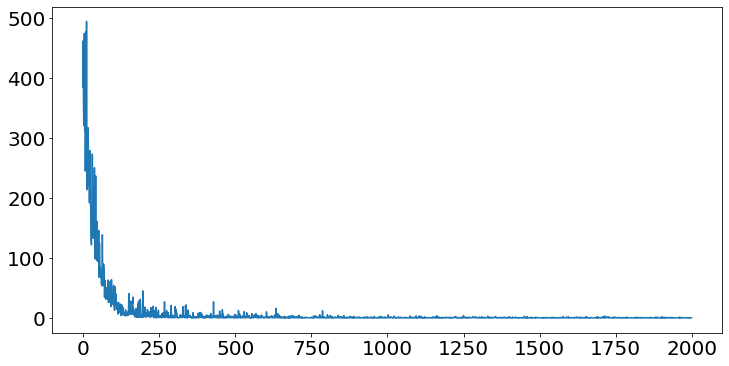

In [32]:
import pyro.distributions as dist

#------Define the process mdoel---------
linear_model = PSTHM.linear_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-5., 5.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Optimize parameter model---------
guide,losses = PSTHM.opti_pyro_mdoel(linear_model,test_X,y,x_sigma,y_sigma,intercept_prior,coefficient_prior,lr=0.02)
#-------Visualize the training loss---------
plt.plot(losses);

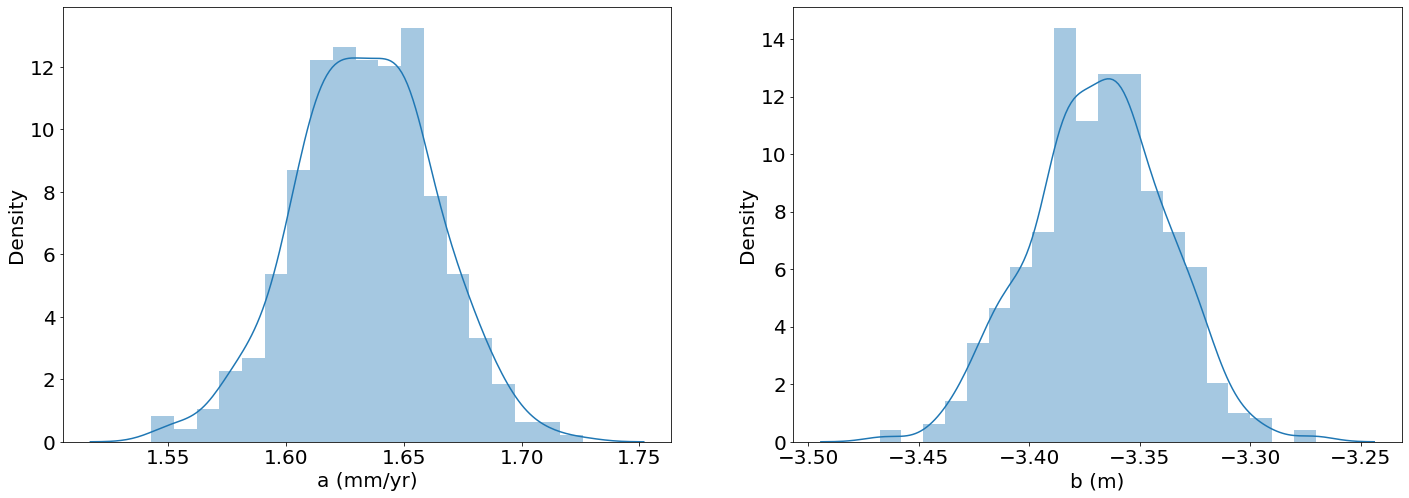

In [33]:
#-------Visualize the optimized model---------
#estimate the posterior distribution of the model parameters from optimized model 
pred_x = torch.tensor([-500,2023])
sample_number = 500 #number of samples to draw from the posterior distribution
a_dis,b_dis,y_pred = torch.zeros(sample_number),torch.zeros(sample_number),torch.zeros(sample_number,len(pred_x))
for i in range(sample_number):
    test_b,test_a = guide().values()
    y_pred[i] = pred_x*test_a + test_b
    a_dis[i] = test_a
    b_dis[i] = test_b
y_pred = y_pred.detach().numpy()
a_dis = a_dis.detach().numpy()
b_dis = b_dis.detach().numpy()

#-------Visualize the posterior distribution of the model parameters---------
plt.figure(figsize=(24,8))
plt.subplot(121)
sns.distplot(a_dis*1000,axlabel='a (mm/yr)')
plt.subplot(122)
sns.distplot(b_dis,axlabel='b (m)');

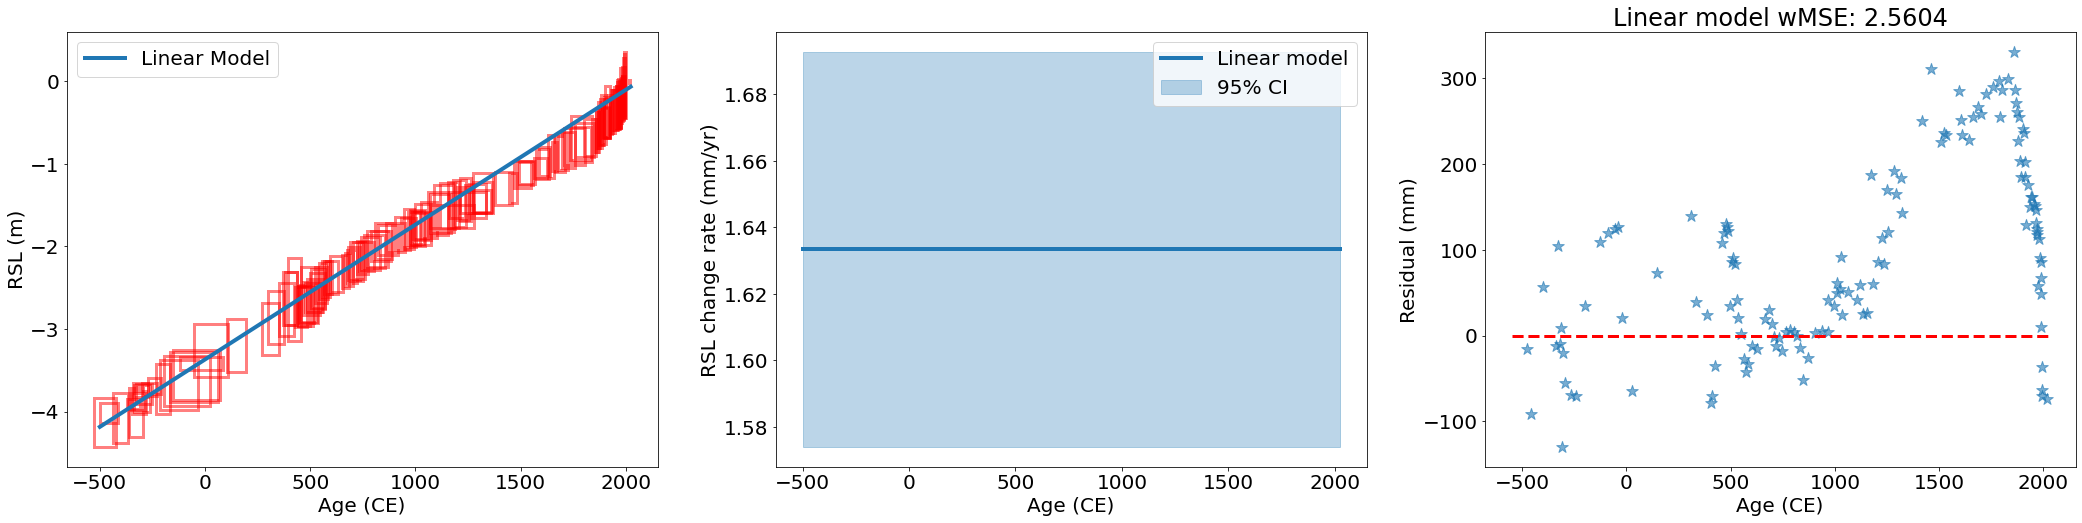

In [35]:
a_mean,a_std = np.mean(a_dis),np.std(a_dis)
b_mean,b_std = np.mean(b_dis),np.std(b_dis)
mean_pred = np.mean(y_pred,axis=0)

#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(pred_x,mean_pred,color='C0',linewidth=4,label='Linear Model')
# ax.set_xlim(-550,2025)
# ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=4,label='Linear model')
plt.fill_between(pred_x,(a_mean-2*a_std)*1000,(a_mean+2*a_std)*1000,color='C0',alpha=0.3,label='95% CI')
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.legend()

ax3 = plt.subplot(133)
f_linear= interpolate.interp1d(pred_x,mean_pred)
linear_prediction = f_linear(X)
plt.scatter(X,(linear_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')

plt.ylabel('Residual (mm)')
plt.title('Linear model wMSE: {:4.4f}'.format(PSTHM.cal_wMSE(y.detach().numpy(),linear_prediction,y_sigma.detach().numpy())))
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.show()



Now, you can see that instead of a single estimate of RSL trend and rate by a hand-drawn model (so-called the deterministic model), we are now able to infer posterior distributions of process model paraemters (sea-level rise rate and intercept coefficients) and of sea-level change trend and rate (so-called the Bayesian model). Therefore, we can start to quantify the uncetaitny of each parameter and prediction results.

However, the Bayesian method does not guarantee a better prediction performance as you can see here the MSE for this Bayesian model is actually higher than the hand-drawn model and the residual looks much more structed as well (a good performance should present residuals with no temporal structure with near stationary distribution). Instead of inference method (deterministic vs Bayesian), the process model choice usually has more impact on model performance, so have good a think about which model fits the best for yoru own problem. 

Based on the wMSE and residual structure above, we found that assuming a single sea-level rise rate in New Jersey is not a good choice. So instead of using a single RSL rate for the whole period, we can use one multiple rates for different periods, the change-point model.


#### 3. Change-point model

The change-point model is a popular process model to infer time series data because it can not only infer the rate of change in different periods of time but also when the rate is chaning, a very handy property for inferring abrupt change in sea level and climate science (see examples like [Caesar et al., 2021](https://www.nature.com/articles/s41561-021-00699-z)). This change-point model we used here is based on a [change-point modelling blog](https://www.niamhcahill.com/post/cptutorial/) by Niamh Cahill.  

The change point model separates the whole time period into seveal partitions where each partition has its own sea-level change rate. It is possible assign the number of change points (e.g., [Cahill et al., 2015](https://iopscience.iop.org/article/10.1088/1748-9326/10/8/084002)) or we can let the data itself to infer the number of change point (e.g., [Sambridge 2016](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JB012901)). Here we will use the former model and so you can assign the number of change-point ($j$) you want to use. In this case, the parameters here we try to infer are change-point locations ($\Iota$) and its uncertainty ($\sigma_{\Iota}$):
$$
\Iota = [\iota_{1},\iota_{2}...\iota_{j}]\\
\sigma_{\Iota} = [\sigma_{\iota_{1}},\sigma_{\iota_{2}}...\sigma_{\iota_{j}}]
$$  
sea-level change rate at different partitions ($A$) and its uncertainty ($\sigma_{A}$):

$$
A = [a_{1},a_{2}...a_{j+1}]\\
\sigma_{A} = [\sigma_{a_{1}},\sigma_{a_{2}}...\sigma_{a_{j+1}}]
$$
and intercept of initial points ($b_{1}$), indicating sea level at oldest age of observational data ($t_{min}$,here is -476). Note the definition of $b_{1}$ here is different to $b$ in a linear model.

In this case, this change-point model can be expressed as:

$$
f_{cp}(t_{i}) = b_{1} + a_{1}(t_{i} -t_{min}) \;\;\;\;\; if \;\; t_{min}< t_{i} \leq \iota_{1} \\ 
f_{cp}(t_{i}) = b_{2}+ a_{2}(t_{i} - \iota_{1})  \;\;\;\;\; if \;\; \iota_{1} <t_{i} \leq \iota_{2} \\ 
.\\
.\\
.\\
f_{cp}(t_{i}) = b_{j+1} + a_{j+1}(t_{i} - \iota_{j})\;\;\;\;\; if \;\; \iota_{j} <t_{i}\\ 
$$
where $b_{2}\;...b_{j+1}$ can be calculated by:
$$
b_{2} = b_{1} + a_{1}(\iota_{1}-t_{min})\\
b_{3} = b_{1} + a_{1}(\iota_{1}-t_{min}) + a_{2}(\iota_{2}-\iota_{1})
.\\
.\\
.\\
b_{j+1} = b_{1} +  a_{1} (\iota_{1}-t_{min}  )+ \sum^{j}_{p=2}a_{p}(\iota_{p}-\iota_{p-1}) 
$$

The following figure will give you a better idea of how it works with 2 change points, you can change the number of change points by simply changing the parameter `num_change_points` below:

<img width=500px src="CP_example.png"/>

As for linear model, we can express this hierarchical model as:

$$
p(f,\epsilon,\delta, A, b_{0}, \Iota |y) \propto p(y|f,\epsilon,\delta) \cdot p(f| A, b_{0}, \Iota) \cdot p(\epsilon,\delta, A, b_{0}, \Iota)
$$

  0%|          | 0/2000 [00:00<?, ?it/s]

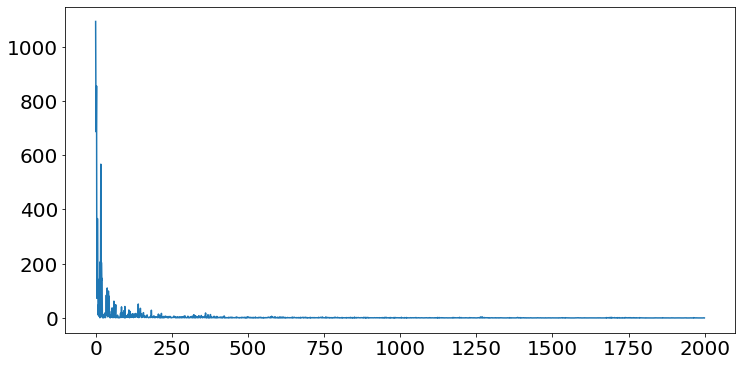

In [26]:
import pyro.distributions as dist

#------Define the process mdoel---------
change_point_model = PSTHM.change_point_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-7., -2.)  #prior distribution for b
coefficient_prior = dist.Uniform(-0.01,0.01) #prior distribution for A

num_change_points = 2
guide,losses = PSTHM.opti_pyro_mdoel(change_point_model,test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior,lr=0.04,number_of_steps=2000)
#-------Visualize the training loss---------
plt.plot(losses);

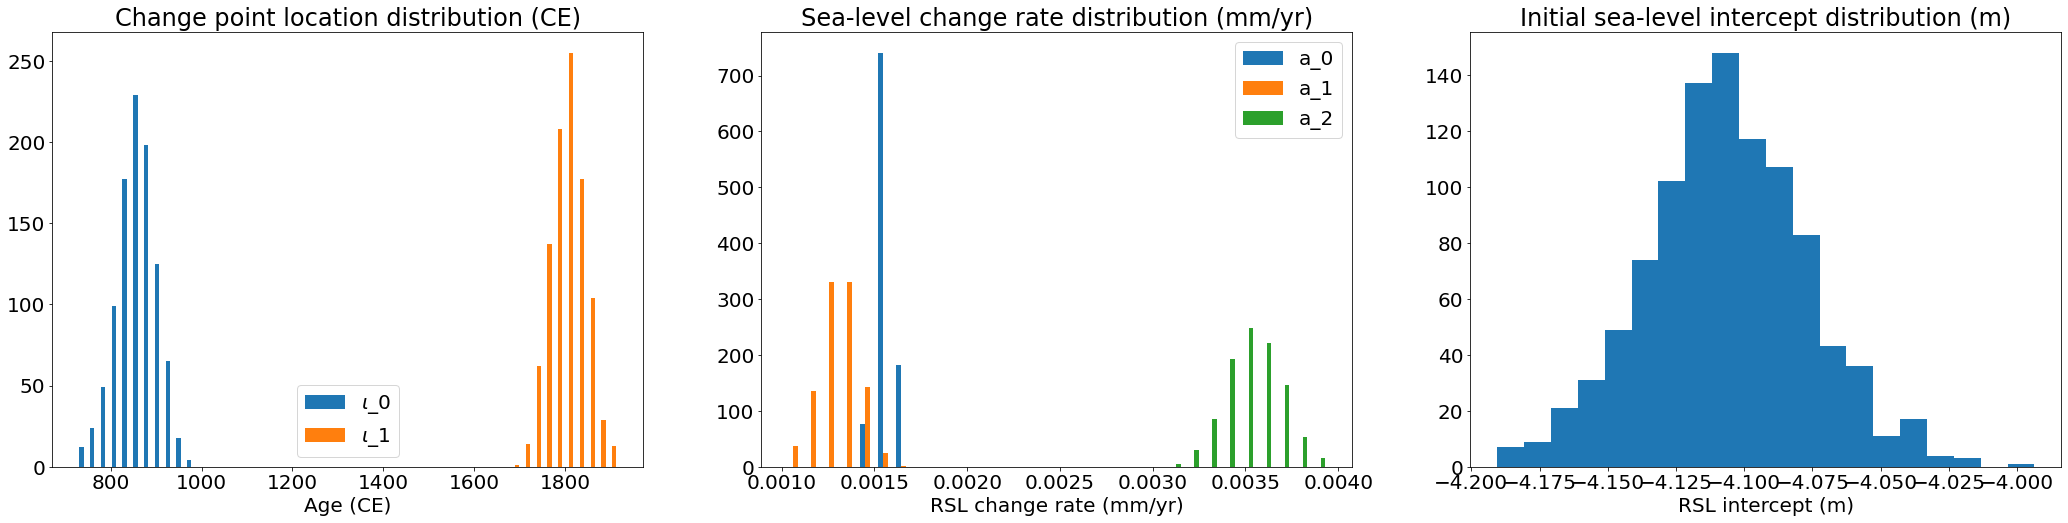

In [27]:
posterior = PSTHM.get_change_point_posterior(guide,1000)

plt.figure(figsize=(36,8))
plt.subplot(131)
plt.hist(posterior['cp'],bins=50,label=[f'$\iota$_{str(i)}' for i in range( posterior['cp'].shape[1])])
plt.xlabel('Age (CE)')
plt.title('Change point location distribution (CE)')
plt.legend()

plt.subplot(132)
plt.hist(posterior['a'],bins=30,label=[f'a_{str(i)}' for i in range( posterior['a'].shape[1])])
plt.xlabel('RSL change rate (mm/yr)')
plt.legend()
plt.title('Sea-level change rate distribution (mm/yr)')

plt.subplot(133)
plt.hist(posterior['b'],bins=20)
plt.xlabel('RSL intercept (m)')
plt.title('Initial sea-level intercept distribution (m)');

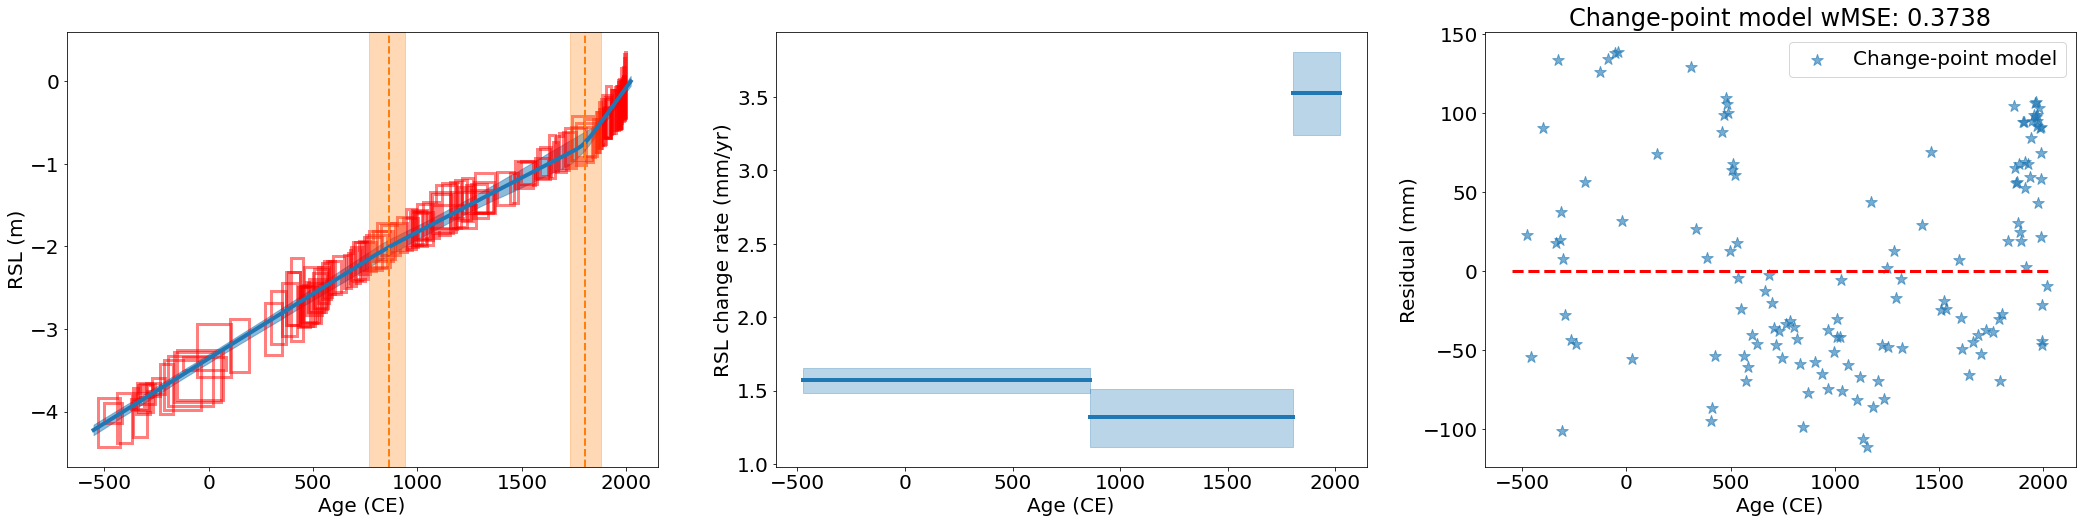

In [29]:
forward_x = torch.arange(-550,2025,5)
change_point_pred = np.zeros([1000,len(forward_x)])
for i in range(1000):
    change_point_pred[i,:] = PSTHM.change_point_forward(num_change_points,posterior['cp'][i],forward_x[:,None],test_X,posterior['a'][i],posterior['b'][i])
change_point_pred_2p5,change_point_pred_50,change_point_pred_97p5 = np.percentile(change_point_pred,[2.5,50,97.5],axis=0)
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(forward_x,change_point_pred_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_2p5,change_point_pred_97p5,color='C0',alpha=0.5,label='95 CI')

for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.legend()
ax2 = plt.subplot(132)
plot_time = [X.min(),*posterior['cp'].mean(axis=0),forward_x.max()]
for i in range(posterior['a'].shape[1]):
    a_2p5,a_50,a_97p5 = np.percentile(posterior['a'][:,i],[2.5,50,97.5])*1000
    plt.plot(plot_time[i:i+2],[a_50,a_50],color='C0',linewidth=4)
    plt.fill_between(plot_time[i:i+2],[a_2p5,a_2p5],[a_97p5,a_97p5],color='C0',alpha=0.3)
plt.xlabel('Age (CE)')
plt.ylabel('RSL change rate (mm/yr)')

ax3 = plt.subplot(133)
f_cp = interpolate.interp1d(forward_x,change_point_pred_50)
cp_prediction = f_cp(X)
ax3.scatter(X,(cp_prediction-y.detach().numpy())*1000,s=150,marker='*',color='C0',alpha=0.6,label = 'Change-point model')
linear_prediction = f_linear(X)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.legend()
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.title('Change-point model wMSE: {:4.4f}'.format(PSTHM.cal_wMSE(y.detach().numpy(),cp_prediction,y_sigma.detach().numpy())));


Compared with a linear model, the change-point model presents a much lower wMSE with less structured residual distribution, indicating a significantly better performance on New Jersey sea-level data. If we look at the sea-level change rate here and hand-drawn model above, we can find out that the hand-drawn model is acutally a change-point model as well. By comparing the inferenceing results by hand-drawn and change-point models, we can tell that altough hand-drawn model do predict an abrupt RSL rate change at 1800 but it may not as robust and interpretable as change-point model. 

Additionally, based on this change-point model, we can see that sea-level rise rate increased dramatically since 1803.3 CE (1769.89-1836.36 CE, 95% credible interval; CI) from 1.3 mm/yr (1.2-1.5 mm/yr 95% CI) to 3.5 mm/yr (3.4-3.7 mm/yr, 95% CI), which agrees quite well with the timing of industrial revolution. 

#### 4. Gaussian Process model

Gaussian Process (GP) is a nonparametric and Bayesian approach used to infer temporal (or spatio-temporal) variation of sea-level change, including magntiude and rate. In a GP, the relationship among any arbitrary set of points (e.g., in time, or in space and time) is a multivariate normal distribution defined by a mean vector and a covariance matrix (or kernel). Compared to using other parametric models (e.g., linear mdoel, change-point model) to infer time series, GP time-series models have much more flexibility because the shape of the curve is driven by the covariance matrix, which is estimated conditional upon the data, as opposed to a predetermined functional form. 

GP-based technique is quite popular among sea-level science, you can see it in papers like [Kopp et al., 2009](https://www.nature.com/articles/nature08686), [Khan et al., 2017](https://www.sciencedirect.com/science/article/pii/S0277379116303304?casa_token=tWT35cjkorAAAAAA:eYvTa65bm0kIdkUPZb1d7OZjGjl2itDd15FQ9qaSqUmVNssKTVOetOir1OWV62qleehmIw8kUQ), [Walker et al., 2022](https://www.nature.com/articles/s41467-022-28564-6) etc... If you don't have background in statistics or Gaussian Process, reading [this blog](https://www.niamhcahill.com/post/gp_tutorial/) by Niamh Cahill will be very helpful.

For GP based process level model, sea-level process can be represented by:
$$
f_{GP}(t) \sim GP(\mu(t),K(t,t'))
$$
where $\mu(t)$ is a mean function, which is used to map input variables (time or space and time) into output variable (RSL). A popular choice for many sea-level studies is using zero-mean function, indicating $\mu(t)=0$ everywhere, therefore where there is no data, the GP model will predict a 0 output. In this case, the prediction will dominantly influenced by covaraince function $K(t,t')$, i.e., kernel, which defines prior expectations about the way in which information is shared between time points (or time and space points). There are several kernel options in GP process model, each kernel has different properties therefore it represent our prior knowledge on the latent process (i.e., sea-leve change). For modelling sea-level change, the commonly-used kernels are: (1) Linear kernel; (2) Squared exponential kernel; (3) Matérn family kernels; (4) Dot-product kernel; (5) Rational squadratic kernel. In this tutorial we will use squared exponential kernel for illustration, for more details of different kernels, please check out the tutorial series for Gaussian Process. 

The squared exponential kernel, so-called RBF kernel can be written as:
$$
k_{RBF}(t,t') = \sigma_{RBF}^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$
where $\sigma_{RBF}$ is an amplitude hyperparameter and $l$ is a length scale hyperparameter.
